# Семинар 3
# SVD и приложения

## Напоминание

- Любую матрицу можно представить в виде 

$$A = U\Sigma V^*,$$

где $U$ и $V$ – унитарны, а $\Sigma$ – диагональная с неотрицательными числами на диагонали, которые называются сингулярными числами


In [25]:
import numpy as np

# A -> ||A||_2 = \sigma_{\max}(A)
# AU -> ||AU||_2 = \sigma_{\max}(AU) = \sigma_{\max}(A)
# AQ = U\Sigma V^*Q
n = 100
m = 10

A = np.random.randn(n, m)
u, s, vt = np.linalg.svd(A, compute_uv=True, full_matrices=False)

print(u.shape, v.shape, s.shape)

print(np.linalg.norm(A - u @ (s[:, np.newaxis] * vt)))
print(np.linalg.norm(A))
k = 9
Q, _ = np.linalg.qr(np.random.randn(m, k))
print(Q.shape)
print(np.linalg.norm(Q.T @ Q - np.eye(k)))
print(np.linalg.norm(A @ Q))
print((vt @ Q) @ (vt @ Q).T)

(100, 10) (10, 10) (10,)
3.49858832153388e-14
30.990900627645342
(10, 9)
1.2844830235514342e-15
29.289080176309902
[[ 0.76041218  0.07576015  0.17157413 -0.10205825  0.14665565 -0.2264393
  -0.01973752  0.02995858  0.16190915 -0.19054666]
 [ 0.07576015  0.97604385 -0.05425352  0.03227188 -0.04637404  0.07160246
   0.00624121 -0.00947322 -0.05119735  0.06025283]
 [ 0.17157413 -0.05425352  0.87713197  0.07308617 -0.10502335  0.16215819
   0.01413448 -0.021454   -0.11594672  0.13645468]
 [-0.10205825  0.03227188  0.07308617  0.95652581  0.06247154 -0.09645732
  -0.00840768  0.01276159  0.06896913 -0.08116798]
 [ 0.14665565 -0.04637404 -0.10502335  0.06247154  0.91022966  0.13860722
   0.01208166 -0.01833814 -0.09910726  0.11663675]
 [-0.2264393   0.07160246  0.16215819 -0.09645732  0.13860722  0.78598763
  -0.01865433  0.02831447  0.15302362 -0.18008951]
 [-0.01973752  0.00624121  0.01413448 -0.00840768  0.01208166 -0.01865433
   0.998374    0.00246802  0.01333826 -0.01569745]
 [ 0.029958

### Приложение 1: тематическое моделирование и латентный семантический поиск

- Дан набор документов
- Необходимо разбить его на темы
- Модель мешка слов
- Для обеих задач нужно некоторое вложение (embedding) документов в $\mathbb{R}^n$

### Модель мешка слов ("bag-of-words")

- Документ – это набор слов, порядок которых неважен
- Тема – это набор слов, наиболее характерных для неё

### Матрица документов-слов $A$

- Матрица размера $N_{docs} \times N_{terms}$
- Чем её заполнить?

### Возможные варианты

- Элемент $(i, j)$ – число вхождений слова $j$ в документ $i$
- Элемент $(i, j)$ - tf-idf для слова $j$ и документа $i$

Tf-Idf – произведение 

- tf = частота встречаемости слова в документе и 

- idf = $\log \frac{|D|}{|\{ d \in D \mid t \in d \}|}$, то есть логарифм отношения числа всех документов к числу документов, в которых есть слово, для которого вычисляется tf-idf. 

**Q:** какими свойствами будет обладать матрица $A$?

## Как из SVD получить требуемое вложение?

- Пусть дана матрица $A$
- Для получения вложений в $\mathbb{R}^n$ вычислим SVD для некоторого ранга $d$: $A = U\Sigma V^*$
- Матрица $U$ размера $N_{docs} \times d$, то есть каждый документ описывается некоторым вектором в $\mathbb{R}^d$
- Матрица $V$ размера $N_{terms} \times d$, то есть каждое слово также описывается некоторым вектором в $\mathbb{R}^d$ 

## Другая интерпретация

- Если ранг $d$ – это число тем в коллекции документов, то получаем некоторое распределение слов по темам и документов по темам
- Можно получить самые релевантные слова для каждой темы и самые характерные документы
- Также эти вложения можно использовать как входные данные для более продвинутых алгоритмов кластеризации/классификации
- Подробности будут освещены в курсе про машинное обучение

### Давайте посмотрим, как это всё работает!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spsplin
import scipy.sparse as spsp

### Загрузим данные

In [2]:
documents = []
with open("./test_articles.txt","r") as fin:
    for line in fin.readlines():
        text = line.strip()
        documents.append(text)
print("Total number of Documents:",len(documents))

Total number of Documents: 4551


### Пример документа

In [3]:
documents[1050]

'Half Way review – dispatch from the frontline of the homelessness purgatory In a crushingly personal dispatch from a family pushed off the edge of London’s housing boom, Daisy-May Hudson hits record on her camcorder as she, her mother Beverly and 13-year-old sister Bronte are evicted from their Epping home and forced into the purgatory of the hostels system. The younger sibling, afraid to stay there alone at night, dubs the pebbledashed lodging they are allocated “Hansel and Gretel’s thing in the woods”. They face an all-too-familiar austerity-Britain obstacle course: freefalling living standards, bureaucratic vindictiveness and stonewalling – plus paying a pretty penny (£500 a week) for the privilege. What’s less obvious, and brought home especially well by Hudson’s insider perspective, is the undermining effect on mental health of this loss of control. In one curious sequence, a strained Beverly accuses Bronte of picking arguments; Bronte flatly denies ever opening her mouth. Even i

### Необходимый препроцессинг текста

In [4]:
news_df = pd.DataFrame({'document': documents})

# removing everything except alphabets`
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z#]", " ")

# removing short words
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

/var/folders/r2/8fwp8hwn29q_slh9d8yh34gc0000gn/T/ipykernel_2563/2787892949.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z#]", " ")


In [5]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# tokenization
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization
detokenized_doc = []
for i in range(len(news_df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

news_df['clean_doc'] = detokenized_doc

### До vs. после

In [6]:
news_df.head()

,document,clean_doc
0,Barclays' defiance of US fines has merit Barcl...,barclays defiance fines merit barclays disgrac...
1,How big is Hillary Clinton's lead in the presi...,hillary clinton lead presidential race depends...
2,Zika’s greatest ally is human intransigence Th...,zika greatest ally human intransigence revenge...
3,Fight for the right: Cruz and Rubio spar in Ne...,fight right cruz rubio spar nevada trump chall...
4,Voting day: America finally goes the polls Can...,voting america finally goes polls candidates s...


### Построим матрицу $A$

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
max_features=1000, # keep top 1000 terms 
)

# vectorizer = CountVectorizer(stop_words="english", max_features=100)

X = vectorizer.fit_transform(news_df['clean_doc'])

X.shape

(4551, 1000)

497895 (4551, 1000)


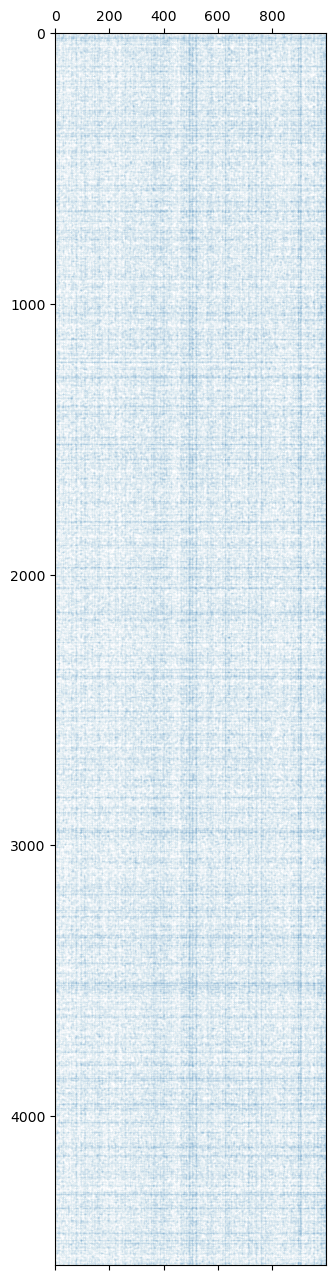

In [8]:
plt.figure(figsize=(20, 16))
plt.spy(X, markersize=0.01)
print(X.nnz, X.shape)

### Специальное SVD для разреженных матриц!

- Как вычислять SVD для плотных матриц было показано на лекции
- Однако у нас матрица разреженная!
- Для таких матриц обычно нужны не все сингулярные числа и вектора, а только первые $k \ll n$
- Для этого используются специальные алгоритмы!
- Пока же просто вызовём функцию из модуля ```scipy.sparse.linalg``` 

In [15]:
u, sigma, v = spsplin.svds(X.asfptype(), k=5)
print(u.shape, v.shape)

(4551, 5) (5, 1000)


### Посмотрим на убывание сингулярных чисел

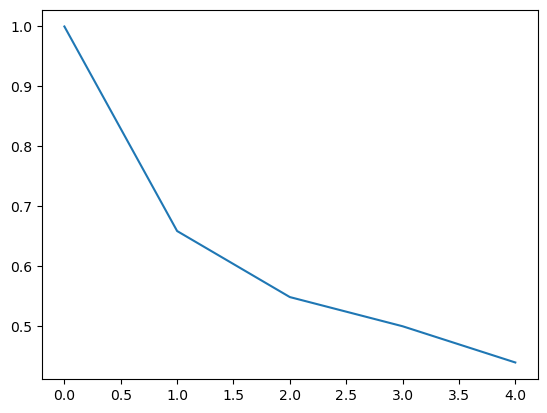

In [16]:
plt.plot(sigma[::-1]/sigma[-1])

In [17]:
terms = vectorizer.get_feature_names()
print(len(terms))
print(terms[:100])

1000
['ability', 'able', 'abortion', 'absolutely', 'abuse', 'accept', 'access', 'according', 'account', 'accounts', 'accused', 'action', 'actor', 'actually', 'added', 'address', 'administration', 'advice', 'afternoon', 'agreed', 'agreement', 'ahead', 'album', 'allow', 'allowed', 'alongside', 'amazon', 'america', 'american', 'americans', 'announced', 'annual', 'answer', 'anti', 'appear', 'appeared', 'appears', 'approach', 'april', 'area', 'areas', 'argument', 'arsenal', 'article', 'artist', 'asked', 'asking', 'asks', 'attack', 'attacks', 'attempt', 'attention', 'audience', 'august', 'australia', 'australian', 'available', 'average', 'avoid', 'away', 'ball', 'band', 'bank', 'banking', 'banks', 'barack', 'barclays', 'based', 'battle', 'beat', 'began', 'beginning', 'believe', 'believes', 'benefit', 'benefits', 'bernie', 'best', 'better', 'biggest', 'black', 'blood', 'blue', 'board', 'body', 'book', 'boris', 'born', 'bournemouth', 'bowie', 'break', 'brexit', 'bring', 'britain', 'british', '

### Темы и "главные" слова для них

In [19]:
for i, comp in enumerate(v):
    print(comp.shape, np.linalg.norm(comp))
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x: x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print("Word: {}, score: {}".format(t[0], t[1]))

(1000,) 0.9999999999999991
Topic 0: 
Word: brexit, score: 0.2323574805521062
Word: britain, score: 0.17638735900062558
Word: referendum, score: 0.15750097605241906
Word: leave, score: 0.15382112490677757
Word: labour, score: 0.14926825473979755
Word: cameron, score: 0.14350282972040695
Word: vote, score: 0.14220225791229452
Word: party, score: 0.1136830767469554
Word: europe, score: 0.10921312901712679
Word: minister, score: 0.10403259053417
(1000,) 0.9999999999999996
Topic 1: 
Word: film, score: 0.3008777486682325
Word: album, score: 0.09505875638927348
Word: music, score: 0.09151156328767941
Word: films, score: 0.07990254954089654
Word: movie, score: 0.07952808913181726
Word: people, score: 0.07305422422366029
Word: women, score: 0.06551778556146691
Word: life, score: 0.06153496871965591
Word: star, score: 0.05829059024275599
Word: songs, score: 0.05582461999391659
(1000,) 0.9999999999999999
Topic 2: 
Word: bank, score: 0.2866918498616411
Word: brexit, score: 0.20540699896913908
Word

### Темы и "главные" документы для них

In [20]:
top_docs = np.argmax(u, axis=0)
print(top_docs)
for i, j in enumerate(top_docs):
    print("Topic {}".format(i))
    print(documents[j])
    print(" ")

[3179 2806 1889  464  658]
Topic 0
Cameron names referendum date as Gove declares for Brexit – as it happened • David Cameron has called for his referendum on Britain’s membership of the EU to take place on 23 June, after the cabinet formally agreed to campaign to stay in despite several minister openly supporting Brexit. Speaking from outside Downing Street, the prime minister said he had secured a good deal with Brussels to give the UK a special status and leaving the EU would “threaten our economic and national security”. • Michael Gove has said that the European Union is encouraging extremism across Europe as he joined five other cabinet ministers in breaking ranks with David Cameron to campaign to take Britain out of the EU. The justice secretary, one of the prime minister’s closest political friends, posed for for a photo with his cabinet colleagues at the headquarters of the Vote Leave campaign group shortly after a rare Saturday cabinet meeting. • A marathon round of talks over

### Найдём по данному запросу ближайший документ

In [21]:
new_request_original = '''There were four minutes remaining and none of the Newcastle United fans had left. 
Even with their team a man down and four goals down, they stayed. 
Even with another reminder of how their well-intentioned manager, Steve Bruce, 
struggles to build on the good work of Rafa Benítez, 
they kept standing there, kept singing, defying the rain and the pain.'''

# removing everything except alphabets`
new_request = new_request_original.replace("[^a-zA-Z#]", " ")

# removing short words
new_request = ' '.join([w for w in new_request.split() if len(w)>3])

# make all text lowercase
new_request = new_request.lower()


# tokenization
tokenized_doc = new_request.split()

# remove stop-words
tokenized_doc = [item for item in tokenized_doc if item not in stop_words]

# de-tokenization
detokenized_request = ' '.join(tokenized_doc)

y = vectorizer.transform([detokenized_request]).toarray().T
y.shape, v.shape

((1000, 1), (5, 1000))

In [22]:
score = u @ (sigma[:, np.newaxis] * v.dot(y))
print(score.shape)
idx_best = np.argsort(score.ravel())
print(idx_best.ravel().shape)
print(documents[idx_best.ravel()[-1]])

(4551, 1)
(4551,)
Premier League: 10 things to look out for this weekend 1) Start of a tough run for the Hammers On the last day of the 2006-07 season Manchester United, who had won the title five days earlier, fielded a weakened side – Cristiano Ronaldo, Ryan Giggs, Paul Scholes, Rio Ferdinand and Nemanja Vidic were all left out of the starting XI – at Old Trafford against a West Ham team who needed at least a point to avoid relegation. Carlos Tevez, who was to join United a few weeks later, scored the only goal on the stroke of half-time. “They couldn’t have come to Old Trafford on a better day,” said Sir Alex Ferguson after the game. “We had already won the league and the edge was off our game.” There was also a 1-0 win in December 2001, against a wretchedly out-of-form United side that were completing a memorably horrific run of five defeats in seven league games. Those two games are the Hammers’ only highlights in a miserable run of top-flight visits to Old Trafford that now exten

In [23]:
print(sorted(score.ravel())[::-1][:10])

[0.19148960929039185, 0.18532805403112093, 0.18360732924076303, 0.18193906546074312, 0.18121928584689237, 0.17711422904386356, 0.17646270547047233, 0.17634829937665883, 0.175147220205643, 0.17448589227333094]


## Приложение 2: рекомендательные системы

### Что дано?

- Матрица пользователь-продукт
- Элементы матрицы – рейтинги, если есть
- Неполное заполнение

## Как использовать SVD?

- Оригинальная работа [*Performance of recommender algorithms on top-n recommendation tasks*](https://dl.acm.org/citation.cfm?id=1864721), Cremonesi, P., Koren, Y., and Turrin, R
- Построим вложение пользователей и продуктов в некоторое подпространство $\mathbb{R}^n$
- Для известных предпочтений найдём наиболее близкие продукты в этом подпространстве
- Как это вычислительно сделать?

### Датасет Movielens с рейтингами фильмов

In [24]:
movies = pd.read_csv('movies.gz', index_col='movieid', header=0, encoding='unicode-escape')[['movienm', 'genreid']]
ratings = pd.read_csv('ratings.gz', header=0)

### Пример записей

In [25]:
movies.head()

,movienm,genreid
movieid,,
1,Toy Story (1995),"Animation, Children's, Comedy"
2,Jumanji (1995),"Adventure, Children's, Fantasy"
3,Grumpier Old Men (1995),"Comedy, Romance"
4,Waiting to Exhale (1995),"Comedy, Drama"
5,Father of the Bride Part II (1995),Comedy


In [26]:
ratings

,userid,movieid,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [27]:
ratings[['userid', 'movieid']].apply(pd.Series.nunique)

userid     6040
movieid    3706
dtype: int64

### Зададим список предпочтений

In [68]:
best_movies = "Boys Life"
target_movies = movies.loc[movies.movienm.str.contains(best_movies, flags=2)]
target_movies

,movienm,genreid
movieid,,
388,Boys Life (1995),Drama
1471,Boys Life 2 (1997),Drama


### Выделим индексы выбранных фильмов

In [69]:
favorite_movies_ids = target_movies.index
print(favorite_movies_ids)

Int64Index([388, 1471], dtype='int64', name='movieid')


### Создадим матрицу с рейтингами 

In [59]:
data_matrix = spsp.csr_matrix((ratings.rating.values.astype('f8'), 
                               (ratings.userid.values, ratings.movieid.values)))
print(data_matrix.shape)

(6041, 3953)


### Вычислим SVD

In [60]:
rank = 300
_, S, Vt = spsplin.svds(data_matrix, k=rank, return_singular_vectors='vh')

### Посмотрим на убывание сингулярных чисел

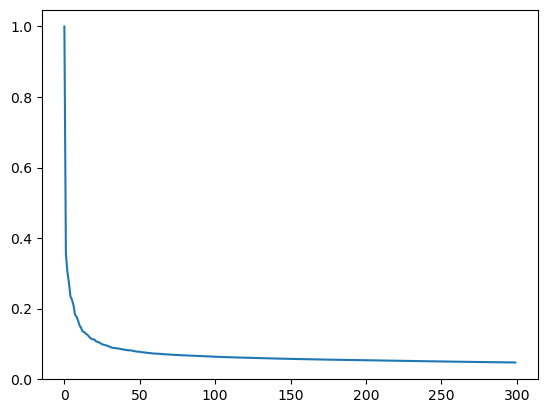

In [61]:
plt.plot(S[::-1] / S[-1])

### Получим корреляции

In [70]:
print(Vt[:, favorite_movies_ids].shape)
correlation = Vt.T @ Vt[:, favorite_movies_ids]
print(correlation.shape)
score = correlation.sum(axis=1)
print(score.shape)
# movies.loc[np.argsort(-Vt.T @ Vt[:, favorite_movies_ids].sum(axis=1))[:15]] # assuming binary preference vector

(300, 2)
(3953, 2)
(3953,)


### Вычислим итоговые рекомендации

In [71]:
top_n = 20
print(np.sort(score)[::-1][:top_n])
movies.loc[np.argsort(-score)[:top_n]]

[0.02100751 0.01975637 0.016306   0.01518557 0.013451   0.01287138
 0.01281839 0.012606   0.01149402 0.01148237 0.01141833 0.01059624
 0.01040606 0.00982641 0.0097866  0.00949453 0.00923221 0.00921775
 0.00914355 0.00865773]


,movienm,genreid
movieid,,
388,Boys Life (1995),Drama
2908,Boys Don't Cry (1999),Drama
529,Searching for Bobby Fischer (1993),Drama
428,"Bronx Tale, A (1993)",Drama
1095,Glengarry Glen Ross (1992),Drama
1721,Titanic (1997),"Drama, Romance"
1235,Harold and Maude (1971),Comedy
3176,"Talented Mr. Ripley, The (1999)","Drama, Mystery, Thriller"
3100,"River Runs Through It, A (1992)",Drama


### Обобщения 

- Учёт контекста позволяет внести в скалярное произведение матрицу похожести. Получим гибридную модель SVD, подробности в [этой работе](https://arxiv.org/pdf/1802.06398.pdf)
- Обзор использования нейронных сетей в рекомендательных системах можно найти [тут](https://arxiv.org/pdf/1707.07435.pdf): неочевидные преимущества по сравнению с моделями, основанными на матричных разложениях
-  [Блог про рекомендательные системы](https://www.eigentheories.com/archive.html#)